# Performance of segmentation models

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [2]:
def iou_metric(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    intersection = np.sum(np.abs(y_true * y_pred))
    union = np.sum(np.abs(y_true) + np.abs(y_pred)) - intersection
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero
    return iou

def dice_coefficient(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    intersection = np.sum(np.abs(y_true * y_pred))
    dice = (2. * intersection) / (np.sum(np.abs(y_true)) + np.sum(np.abs(y_pred)) + 1e-7)  # Add epsilon to avoid division by zero
    return dice

## Atrophy

In [3]:
# Load the model architecture and weights
with open('../features_segmentation/Atrophy.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('../features_segmentation/Atrophy.weights.h5')

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, dice_coefficient])

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-11-28 19:44:26.291808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-28 19:44:26.292112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Optic disc

In [ ]:
# Load the model architecture and weights
with open('../features_segmentation/OD.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('../features_segmentation/OD.weights.h5')

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, dice_coefficient])

## Test on PALM dataset

In [4]:
def load_data(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}.bmp"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Convert to numpy arrays
                img_array = img_to_array(img) / 255.0  # Normalize the image between 0 and 1
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [5]:
# choose for either atrophy or optic disc

image_dir = 'path/to/images'
mask_dir = 'path/to/masks'

# Image size (height, width, channels)
image_size = (256, 256)

images, masks = load_data(image_dir, mask_dir, image_size)

Skipping N0010.jpg as no corresponding mask was found.
Skipping T0042.jpg as no corresponding mask was found.
Skipping V0379.jpg as no corresponding mask was found.
Skipping V0345.jpg as no corresponding mask was found.
Skipping T0254.jpg as no corresponding mask was found.
Skipping V0190.jpg as no corresponding mask was found.
Skipping V0147.jpg as no corresponding mask was found.
Skipping T0283.jpg as no corresponding mask was found.
Skipping P0076.jpg as no corresponding mask was found.
Skipping T0334.jpg as no corresponding mask was found.
Skipping N0158.jpg as no corresponding mask was found.
Skipping V0231.jpg as no corresponding mask was found.
Skipping V0225.jpg as no corresponding mask was found.
Skipping V0032.jpg as no corresponding mask was found.
Skipping T0335.jpg as no corresponding mask was found.
Skipping T0309.jpg as no corresponding mask was found.
Skipping T0296.jpg as no corresponding mask was found.
Skipping T0269.jpg as no corresponding mask was found.
Skipping V

In [6]:
results = model.predict(images)
results_binary = (results > 0.5).astype(int)

2024-11-28 19:44:43.007343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-28 19:44:43.089649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 27s 941ms/step


In [7]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_binary[i]  # Predicted mask
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

Average IoU on test set: 0.9364507682383244
Average Dice Coefficient on test set: 0.9652134453915172


1/1 [==============================] - 0s 182ms/step


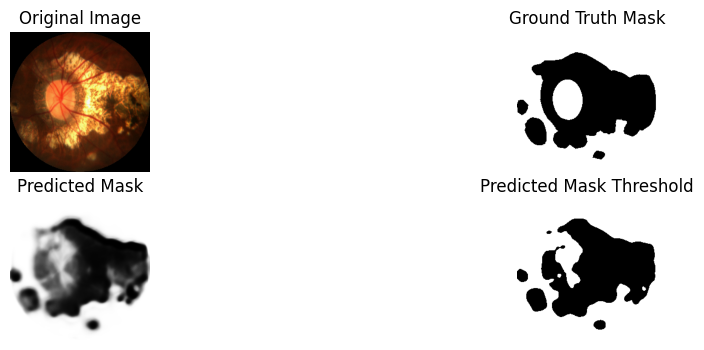

In [8]:
import matplotlib.pyplot as plt
# 149, 150
image = images[127]  # Original test image
true_mask = masks[127]  # Ground truth mask
pred_mask = model.predict(np.expand_dims(image, axis=0))  # Predict mask
pred_mask_binary = (pred_mask > 0.5).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')

plt.show()

AUC-ROC Score: 0.959763144550972
Accuracy: 0.9448698898841594


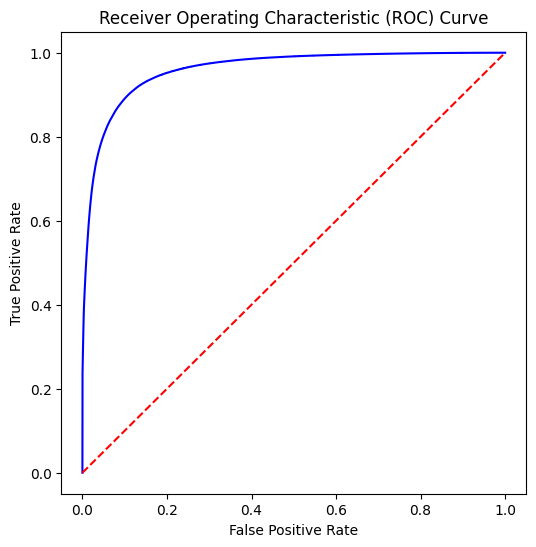

In [9]:
# Flatten the masks and predictions
y_true = masks.flatten()  # Flatten ground truth masks
y_pred = results.flatten()  # Flatten predicted probabilities (before thresholding)

# Calculate AUC
auc_score = roc_auc_score(y_true, y_pred)
print("AUC-ROC Score:", auc_score)

# Accuracy
accuracy = accuracy_score(y_true, y_pred > 0.5)
print("Accuracy:", accuracy)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()